<div dir="rtl">

این تمرین با استفاده از `jupyter notebook` پایتون پیاده سازی شده است.

تمامی داده های مورد استفاده، صورت تمرین و کدها  را می توانید در  [اینجا](https://github.com/Fatimaslh/Data-maining) بیابید.

در این نوت بوک ما میخواهیم داده های یک مجموعه داده از سایت kaggle را مدل سازی کنیم. این داده ها مربوط به مشخصات خانه های مسکونی و قیمت آن ها می باشد. در ادامه مدلی طراحی خواهد شد تا با استفاده از آن بتوانیم قیمت یک خانه را بر اساس ویژگی های آن پیش بینی نماییم.

داده ها دارای 83 ویژگی (متراژ، تعداد اتاق، محله و ...) می باشد که می توانید جزئیات و مقادیر ممکن برای هر ویژگی را در فایل `data_description.txt` مشاهده نمایید.

ابتدا کتابخانه های های لازم را فراخوانی میکنیم.
</div>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/data_description.txt
data/train.csv
data/test.csv


<div dir="rtl">
<h2><b>1. جمع آوری داده (sampling)</b></h2></br>
همانطور که مشاهده میکنید داده های ما به دو مجموعه برای آموزش و دیگری برای تست تقسیم شده است.

در ادامه داده ها را به کمک کتابخانه pandas لود میکنیم و بخشی از آن را نمایش میدهیم.
</div>

In [2]:
# Loading Training and Test Data
train_data_file = "data/train.csv"
test_data_file = "data/test.csv"

X = pd.read_csv(train_data_file, index_col='Id')
X_test = pd.read_csv(test_data_file, index_col='Id')

X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


<div dir="rtl">
<h2><b>2. اکتشاف (exploration)</b></h2></br>
برای نمونه رابطه میان قیمت خانه ها و مساحت آن ها را نمایش میدهیم. می توان مشاهده کرد که ویژگی مساحت به تنهایی قابلیت پیش بینی قیمت را ندارد و باید با ویژگی های دیگری همراه باشد.

در ادامه با استفاده از روش های آماری، آن دسته از ویژگی هایی که مقادیر مشترک زیادی میان داده های ما دارند و اطلاعات مفیدی به نمیدهند حذف میکنیم:

</div>

/tmp/ipykernel_11376/989724714.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(x_sorted[ : 1450], y_sorted[ : 1450], 'o')


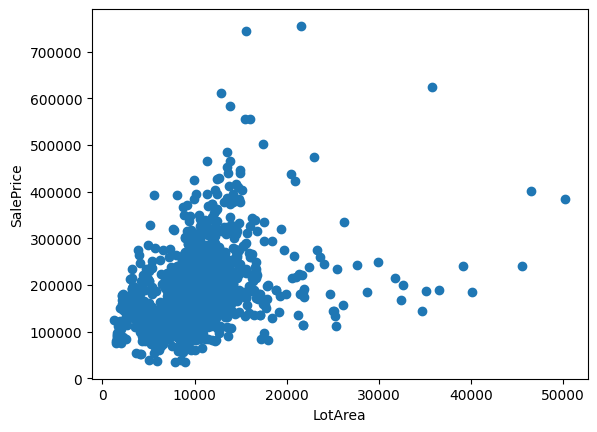

In [4]:
# plot LotArea vs SalePrice
# remove outliers
x_sorted_index = X.LotArea.sort_values().index
x_sorted = X.LotArea.sort_values()
y_sorted = y[x_sorted_index]
plt.plot(x_sorted[ : 1450], y_sorted[ : 1450], 'o')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.show()


In [5]:
# Checking columns

low_cardinality_columns = [col for col in X.columns if X[col].nunique() < 10 and X[col].dtype == "object"]
num_columns = [col for col in X.columns if X[col].dtype in ["int64", "float64"]]

required_columns = low_cardinality_columns + num_columns
high_cardinality_columns = [col for col in X.columns if col not in required_columns]

print(required_columns)
print("Dropped_columns", high_cardinality_columns)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea

<div dir="rtl">
<h2><b>3. دستکاری (Manipulation)</b></h2></br>

سپس داده های miss شده را با استفاده از کتابخانه `sklearn` پر میکنیم.

</div>

In [6]:
# Defining Pipeine

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score


numerical_transformer = SimpleImputer(strategy="constant")

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant")),
    ("one_hot_encoding", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, num_columns),
        ("categorical", categorical_transformer, low_cardinality_columns)
    ])

<div dir="rtl">
<h2><b>4. آموزش(Modeling)</b></h2></br>

برای انتخاب پارامتر های مناسب برای آموزش مقادیر مختلف را امتحان میکنیم تا بهینه ترین به دست آید.

</div>

In [7]:
def get_scores(n_estimators, learning_rate):
    xgb_regressor_model = XGBRegressor(n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       random_state=0,
                                       n_jobs=4)

    model_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model_run", xgb_regressor_model)
    ])
    
    scores = -1 * cross_val_score(model_pipeline, X, y, cv=3, scoring="neg_mean_absolute_error")
    
    return scores.mean()

# Training the model and finding the appropriate values

results = {}

for i in range(8, 13):
    for j in range(3):
        results[(100*i, 0.04 + 0.01*j)] = get_scores(100*i, 0.04 + 0.01*j)

{(800, 0.04): 16426.066360313274, (800, 0.05): 16644.35843671902, (800, 0.06): 16616.37067847101, (900, 0.04): 16420.687485278242, (900, 0.05): 16644.81792217291, (900, 0.06): 16614.745626356205, (1000, 0.04): 16421.153885892607, (1000, 0.05): 16645.025433508446, (1000, 0.06): 16615.373328139787, (1100, 0.04): 16422.57223537278, (1100, 0.05): 16647.211379823897, (1100, 0.06): 16615.751751592063, (1200, 0.04): 16424.282063426614, (1200, 0.05): 16647.23725164021, (1200, 0.06): 16616.21497778621}


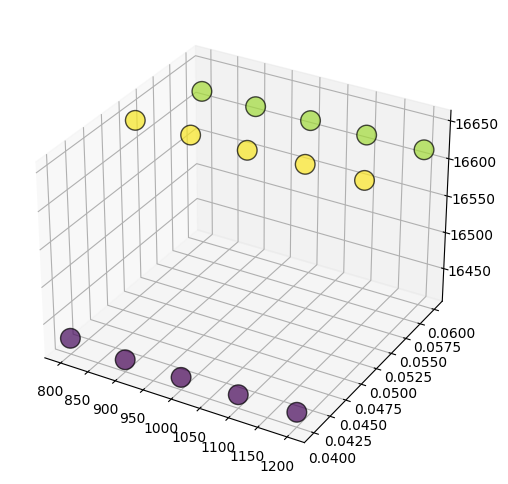

(900, 0.04) 16420.687485278242


In [9]:

print(results)

x_axis = list(each[0] for each in results)
y_axis = list(each[1] for each in results)
error = list(results[each] for each in results)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_axis, y_axis, error,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=error)
plt.show()

min_mae = math.inf
res = None
for each in results:
    if results[each] < min_mae:
        min_mae = results[each]
        res = each
        
print(res, min_mae)

<div dir="rtl">

میزان ارور با توجه به پارامتر ها در شکل بالا قابل مشاهده می باشد. از این نمودار می توانیم بهترین مقدار برای پارامتر ها را مشخص کنیم.

با استفاده از بهینه ترین پارامتر، مدل نهایی را آموزش میدهیم:
</div>

In [10]:
# Thus the minimum error is n_esitimators = 900 and learning_rate = 0.04
# Setting up final model using the required params

xgb_regressor_model = XGBRegressor(n_estimators=res[0],
                                   learning_rate=res[1],
                                   random_state=0,
                                   n_jobs=4)

model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model_run", xgb_regressor_model)
])

# Fitting the input and predicting the results
model_pipeline.fit(X, y)


# Model Prediction
preds = model_pipeline.predict(X_test)

In [11]:
#Saving Output

output = pd.DataFrame({"Id": X_test.index, "SalePrice": preds})
output.to_csv("submission.csv", index=False)

<div dir="rtl">
<h2><b>5. ارزیابی (Assessment)</b></h2></br>

خروجی مدل را برای داده های تست نمایش میدهیم:
</div>

In [12]:
output.head()

,Id,SalePrice
0,1461,126472.671875
1,1462,155542.046875
2,1463,187986.968750
3,1464,190310.859375
4,1465,188251.093750


<div dir="rtl">

## <center> با تشکر از توجه شما </center>
</div>